### Git versioning

In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : 03f19d8d1c056fec5562f592814f9526b3e6c0a2 

Commit short SHA: 03f19
Branch:  mensualisation_wip
Date (y/m/d): 2016-06-01 08:56:21  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : 4581a82fd1456cbe0bdd86ab1b57db6fef37c8cf  Date: 2016-05-31 15:46:50 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [2]:
%matplotlib inline
from __future__ import division

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

# Create Survey Scenario

In [3]:
period = periods.period(2009)

In [4]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [5]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(59874,) (49016,) (55306,) (112359,)


In [6]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [7]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [8]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [10]:
split_by_roles('age_en_mois', 'famille')

{0: array([950, 737, 348, ..., 394, 551, 281], dtype=int32),
 1: array([  916, -9999, -9999, ..., -9999,   539,   270], dtype=int32),
 2: array([-9999, -9999, -9999, ..., -9999,   222, -9999], dtype=int32),
 3: array([-9999, -9999, -9999, ..., -9999,   161, -9999], dtype=int32),
 4: array([-9999, -9999, -9999, ..., -9999,   118, -9999], dtype=int32),
 5: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 6: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 7: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 8: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 9: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 10: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 11: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32)}

In [11]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [12]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [105]:
filtre_pere = simulation.holder_by_name["quimen"].array == 0

In [106]:
filtre_mere = simulation.holder_by_name["quimen"].array == 1

In [56]:
pd.Series(simulation.calculate('salaire_imposable') == 
          (simulation.calculate('salaire_imposable') * (filtre_pere | filtre_mere))
         ).value_counts()

True     107793
False      4566
dtype: int64

In [49]:
(simulation.calculate('salaire_imposable') * (filtre_pere | filtre_mere))[:100]

array([     0.        ,      0.        ,      0.        ,    212.00001526,
            0.        ,      0.        ,   3667.        ,  12420.        ,
            0.        ,      0.        ,  22405.99804688,      0.        ,
            0.        ,      0.        ,      0.        ,  20803.        ,
            0.        ,      0.        ,   9471.        ,   2708.        ,
            0.        ,  34245.        ,   9378.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
        22702.00195312,  23838.        ,      0.        ,      0.        ,
        36642.        ,  19707.        ,      0.        ,      0.        ,
        14433.99902344,      0.        ,  20996.        ,  30205.00195312,
        27333.        ,      0.        ,  27745.00195312,      0.        ,
        24358.99804688,      0.        ,   4275.        ,  22933.00195312,
        28327.99804688,      0.        ,  15672.99902344,  15225.        ,
            0.        ,  

In [112]:
salaire_menage = simulation.calculate('salaire_imposable')*(filtre_pere | filtre_mere)
salaire_femme = simulation.calculate('salaire_imposable')*( filtre_mere)

In [184]:
salaire_pere_non_nul = (simulation.calculate('salaire_imposable')>10) & filtre_pere
salaire_pere_non_nul = sum_array_by_entity(salaire_pere_non_nul, 'menage')
salaire_mere_non_nul = (simulation.calculate('salaire_imposable')>10) & filtre_mere
salaire_mere_non_nul = (sum_array_by_entity(salaire_mere_non_nul, 'menage'))

In [185]:
(simulation.calculate('salaire_imposable'))

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [188]:
filtre_pere

array([ True, False, False, ..., False, False, False], dtype=bool)

In [189]:
salaire_pere_non_nul

array([ 0.,  1.,  0., ...,  1.,  0.,  0.])

In [179]:
salaire_non_nul = salaire_pere_non_nul  & salaire_mere_non_nul 

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [177]:
sum_array_by_entity(salaire_non_nul, 'menage')[:20]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [113]:
salaire_menage = sum_array_by_entity(salaire_menage, 'menage')
salaire_femme = sum_array_by_entity(salaire_femme, 'menage')

In [114]:
filtre_deux_parents = sum_array_by_entity(filtre_mere,'menage')

In [122]:
sum_array_by_entity(filtre_mere,'menage')[:20]

array([ 1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.])

In [121]:
filtre_mere[:20]

array([False,  True, False, False,  True, False,  True, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True], dtype=bool)

In [117]:
filtre_deux_parents[:100]

array([ 1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.])

In [118]:
simulation.holder_by_name["quimen"].array[:100]

array([0, 1, 2, 0, 1, 0, 1, 0, 2, 3, 1, 0, 2, 3, 0, 1, 0, 0, 0, 1, 2, 0, 1,
       2, 3, 4, 0, 2, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 1, 0, 0, 2,
       1, 0, 0, 0, 1, 2, 3, 4], dtype=int16)

In [123]:
salaire_menage=salaire_menage[filtre_deux_parents.astype('bool')]
salaire_femme = salaire_femme[filtre_deux_parents.astype('bool')]

In [158]:
share_of_income = salaire_femme/salaire_menage

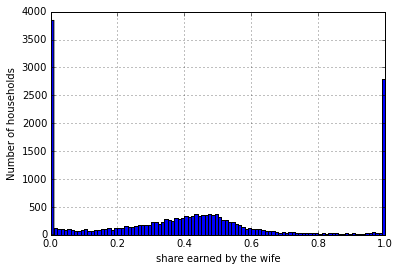

In [165]:
weights = np.ones_like(share_of_income)/float(len(share_of_income))
pd.Series(share_of_income).hist(bins= 100)

plt.ylabel('Number of households')
plt.xlabel('share earned by the wife')

In [157]:
%debug

> /usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py(5649)hist()
   5648                     raise ValueError(
-> 5649                         'weights should have the same shape as x')
   5650         else:

ipdb> w
  <ipython-input-156-c8e5db7d5759>(2)<module>()
      1 #weights = np.ones_like(share_of_income)/float(len(share_of_income))
----> 2 pd.Series(share_of_income).hist(bins= 100, weights=weights)
      3 
      4 plt.ylabel('Number of households')
      5 plt.xlabel('share earned by the wife')

  /usr/local/lib/python2.7/site-packages/pandas/tools/plotting.py(2833)hist_series()
   2831         values = self.dropna().values
   2832 
-> 2833         ax.hist(values, bins=bins, **kwds)
   2834         ax.grid(grid)
   2835         axes = np.array([ax])

> /usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py(5649)hist()
   5647                 if len(w[i]) != len(x[i]):
   5648                     raise ValueError(
-> 5649                         'weights s

AttributeError: max must be larger than min in range parameter.

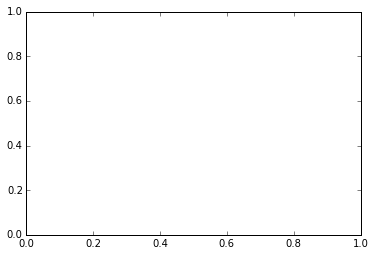

In [150]:
plt.hist(share_of_income)

In [145]:
weights

array([  3.49772648e-05,   3.49772648e-05,   3.49772648e-05, ...,
         3.49772648e-05,   3.49772648e-05,   3.49772648e-05])

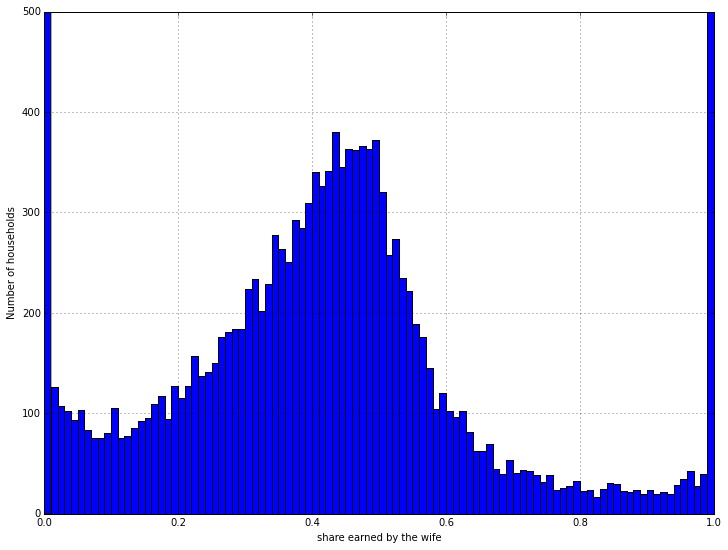

In [151]:
pd.Series(share_of_income).hist(bins= 100, figsize = [12,9])
plt.ylim(0,500)
plt.ylabel('Number of households')
plt.xlabel('share earned by the wife')

In [93]:
salaire_femme

array([     0.,      0.,      0., ...,      0.,  37231.,      0.])

In [13]:
uc_famille.shape

(55306,)

In [14]:
weight_familles.shape

(55306,)

In [15]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [16]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([     0.        ,      0.        ,      0.        , ...,
       -12667.37304688,      0.        ,      0.        ])

In [17]:
revdisp_negatif = (rev_disp_uc < 0)

In [18]:
array = np.zeros(len(weight_menages))
zip_2 = simulation.calculate_add('revdisp_mensuel_annuel')
for var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap","psoc_mensuel", "ppe", "impo_mensuel"]:
    if var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap"]:
        zip_1 = sum_by_entity(var, "menage", roles = None)

    else:
        zip_1 = switch_entity(var, 'menage' , range(12))
        
    assert zip_1.shape == zip_2.shape == revdisp_negatif.shape, '{}{}{}'.format(zip_1.shape, zip_2.shape , revdisp_negatif.shape)
    print var, zip(zip_1[revdisp_negatif][:50], zip_2[revdisp_negatif][:50]), "\n"


rev_trav_mensuel [] 

pen_mensuel [] 

rev_cap [] 

psoc_mensuel [] 

ppe [] 

impo_mensuel [] 



In [19]:
pd.value_counts(revdisp_negatif)

False    49016
dtype: int64

In [20]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    112086
True        273
dtype: int64

In [23]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    45892
1     9220
2      194
dtype: int64
